In [1]:
import pandas as pd
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import csv
from tqdm.auto import tqdm
from haversine import haversine
from itertools import product
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import kmeans as pykmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.metrics import pairwise_distances
from pyclustering.utils.metric import distance_metric, type_metric
from distinctipy import distinctipy
from glob import glob

In [2]:
#Leitura dos dados
tab_ocorrencia = pd.read_csv('./csvs/ocorrencia.csv', sep=';')
tab_ocorrencia_tipo = pd.read_csv('./csvs/ocorrencia_tipo.csv', sep=';')
tab_aeronave = pd.read_csv('./csvs/aeronave.csv', sep=';')
tab_fator_contribuinte = pd.read_csv('./csvs/fator_contribuinte.csv', sep=';')
tab_recomendacao = pd.read_csv('./csvs/recomendacao.csv', sep=';')
tab_reportes_2011_2020 = pd.read_csv('./csvs/reportes_2011_2020.csv', sep=';', encoding='latin_1', low_memory=False)

In [3]:
#Função para limpar os dados de latitude e longitude
#Tudo que não estiver no formato decimal é removido
#Dados faltantes, representados de diversas formas
#Como '***' '******' também são removidos
def limpar_lat_lon(x):
    x = x.strip()
    if ',' in x:
        x = x.replace(',', '.')
    if ' ' in x:
        x = x.replace(' ', '')
    if '\t' in x:
        x = x.replace('\t', '')
    if '\\' in x:
        x = x.replace('\\', '')
    if 't' in x:
        x = x.replace('t', '')
    if '°' in x:
        x = x.replace('°', '')
    if 'S' in x:
        x = x.replace('S', '')
    if 'W' in x:
        x = x.replace('W', '')
    if '’' in x:
        return 'REMOVER'
    if 'NÃOINFORMADO' in x:
        return 'REMOVER'
    if 'ÃOINFORMADO' in x:
        return 'REMOVER'
    if '*' in x:
        return 'REMOVER'
    if 'Longiude' in x:
        return 'REMOVER'
    if x.count('.') > 1:
        return 'REMOVER'
    return x

In [4]:
#Como queremos clusterizar os dados temos que remover dados faltantes
lat_lon = tab_ocorrencia[tab_ocorrencia['ocorrencia_latitude'].notna()]

lat_lon['ocorrencia_latitude'] = lat_lon['ocorrencia_latitude'].apply(limpar_lat_lon)
lat_lon['ocorrencia_longitude'] = lat_lon['ocorrencia_longitude'].apply(limpar_lat_lon)

lat_lon = lat_lon[lat_lon['ocorrencia_latitude'] != 'REMOVER']
lat_lon = lat_lon[lat_lon['ocorrencia_longitude'] != 'REMOVER']

lat_lon['ocorrencia_latitude'] = lat_lon['ocorrencia_latitude'].astype(float)
lat_lon['ocorrencia_longitude'] = lat_lon['ocorrencia_longitude'].astype(float)

#Removendo outliers
#Escolhi os limites para a clusterização considerando que
#A ideia era colocar pessoas nos centros dos clusters
#Para que eles fossem de carro até o local
#Removi pontos muito longínquos

lat_lon = lat_lon[lat_lon['ocorrencia_latitude'] > -40]
lat_lon = lat_lon[lat_lon['ocorrencia_latitude'] < 10]

lat_lon = lat_lon[lat_lon['ocorrencia_longitude'] >  -180]
lat_lon = lat_lon[lat_lon['ocorrencia_longitude'] <  -20]

latitudes = lat_lon['ocorrencia_latitude'].to_numpy()
longitudes = lat_lon['ocorrencia_longitude'].to_numpy()

E:\ProgramData\Anaconda3\envs\comecapandas\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\ProgramData\Anaconda3\envs\comecapandas\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
coordinates = np.asarray(list(zip(latitudes, longitudes)))

Decidi utilizar o KMeans do pyclustering porque ele permite utilizar diferentes funções para a clusterização
É importante utilizarmos a distancia de haversine neste contexto. Distancia euclidiana quando utilizada para lat e lon não considera a circunferência da Terra, o que não é correto

In [6]:
#Adaptador para função haversine, pyclustering espera funções neste formato
haversine_py = distance_metric(type_metric.USER_DEFINED, func=haversine)

Como o Kmeans depende inicializações aleatórias é interessante que o experimento seja repetido diversas vezes, para eliminar problemas de inicialização ruim.

O experimento a seguir demonstra o melhor lugar para colocar T times de investigação de forma a minimizar a distância máxima percorrida por cada time.

In [7]:
n_times = 100

melhor_instancia = None
max_dist = float('inf')

for teste in tqdm(range(5)):
    initial_centers = kmeans_plusplus_initializer(coordinates, n_times).initialize()
    kmeans_instance = pykmeans(coordinates, initial_centers, metric=haversine_py)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()


    dists = []
    for idx in range(len(clusters)):
        dists.append(pairwise_distances(np.asarray(centers[idx]).reshape(1, -1), coordinates[clusters[idx]], metric=haversine).max())
        
    if np.max(dists) < max_dist:
        melhor_instancia = kmeans_instance
        max_dist = np.max(dists)

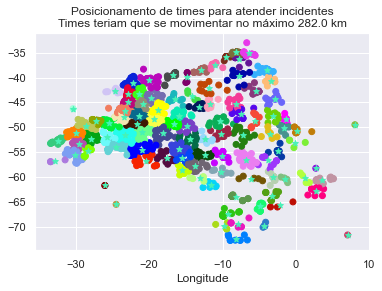

In [8]:
clusters = melhor_instancia.get_clusters()
centers = np.asarray(melhor_instancia.get_centers())

cluster_label = [0 for i in range(len(coordinates))]

colors = distinctipy.get_colors(len(clusters)+1)


for i, cluster in enumerate(clusters):
    for point in cluster:
        cluster_label[point] = colors[i]

plt.scatter(coordinates[:, 0], coordinates[:, 1], c=cluster_label)
plt.scatter(centers[:, 0], centers[:, 1], color=colors[-1], marker='*')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Posicionamento de times para atender incidentes\nTimes teriam que se movimentar no máximo {np.ceil(max_dist)} km')
plt.savefig('tenho_x_times.png', dpi=300)
plt.show()

De maneira semelhante ao experimento anterior podemos buscar a quantidade de times necessária para que a distancia máxima percorrida seja D.

In [9]:
n_times_inicial = 3
limite_distancia = 250 #em km
fator_aumento_times = 10
max_dist = float('inf')

initial_centers = kmeans_plusplus_initializer(coordinates, n_times_inicial).initialize()
kmeans_instance = pykmeans(coordinates, initial_centers, metric=haversine_py)
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
centers = kmeans_instance.get_centers()

dists = []
for idx in range(len(clusters)):
    dists.append(pairwise_distances(np.asarray(centers[idx]).reshape(1, -1), coordinates[clusters[idx]], metric=haversine).max())

if np.max(dists) < max_dist:
    melhor_instancia = kmeans_instance
    max_dist = np.max(dists)
    
if max_dist > limite_distancia:
    print(f'Com {n_times_inicial} times a distancia máxima percorrida seria {int(max_dist)}, o que não é aceitavel.')
else:
    print(f'Com {n_times_inicial} times a distancia máxima percorrida seria {int(max_dist)}, o que é aceitavel.')
    
while max_dist > limite_distancia:
    n_times_inicial += fator_aumento_times
    initial_centers = kmeans_plusplus_initializer(coordinates, n_times_inicial).initialize()
    kmeans_instance = pykmeans(coordinates, initial_centers, metric=haversine_py)
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()

    dists = []
    for idx in range(len(clusters)):
        dists.append(pairwise_distances(np.asarray(centers[idx]).reshape(1, -1), coordinates[clusters[idx]], metric=haversine).max())

    if np.max(dists) < max_dist:
        melhor_instancia = kmeans_instance
        max_dist = np.max(dists)
        
    if max_dist > limite_distancia:
        print(f'Com {n_times_inicial} times a distancia máxima percorrida seria {int(max_dist)}, o que não é aceitavel.')
    else:
        print(f'Com {n_times_inicial} times a distancia máxima percorrida seria {int(max_dist)}, o que é aceitavel.')

Com 3 times a distancia máxima percorrida seria 2208, o que não é aceitavel.
Com 13 times a distancia máxima percorrida seria 1309, o que não é aceitavel.
Com 23 times a distancia máxima percorrida seria 1203, o que não é aceitavel.
Com 33 times a distancia máxima percorrida seria 1047, o que não é aceitavel.
Com 43 times a distancia máxima percorrida seria 1047, o que não é aceitavel.
Com 53 times a distancia máxima percorrida seria 882, o que não é aceitavel.
Com 63 times a distancia máxima percorrida seria 408, o que não é aceitavel.
Com 73 times a distancia máxima percorrida seria 392, o que não é aceitavel.
Com 83 times a distancia máxima percorrida seria 381, o que não é aceitavel.
Com 93 times a distancia máxima percorrida seria 294, o que não é aceitavel.
Com 103 times a distancia máxima percorrida seria 294, o que não é aceitavel.
Com 113 times a distancia máxima percorrida seria 294, o que não é aceitavel.
Com 123 times a distancia máxima percorrida seria 283, o que não é ace

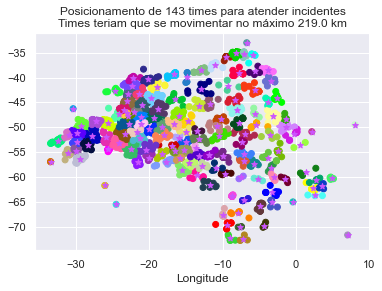

In [10]:
clusters = melhor_instancia.get_clusters()
centers = np.asarray(melhor_instancia.get_centers())

cluster_label = [0 for i in range(len(coordinates))]

colors = distinctipy.get_colors(len(clusters)+1)

for i, cluster in enumerate(clusters):
    for point in cluster:
        cluster_label[point] = colors[i]

plt.scatter(coordinates[:, 0], coordinates[:, 1], c=cluster_label)
plt.scatter(centers[:, 0], centers[:, 1], color=colors[-1], marker='*')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Posicionamento de {len(clusters)} times para atender incidentes\nTimes teriam que se movimentar no máximo {np.ceil(max_dist)} km')
plt.savefig('resultado_otimizacao_distancia.png', dpi=300)
plt.show()

Join entre tabela ocorrencia e fator_contribuinte, para analisarmos se existe alguma relação entre os fatores contribuintes e as posições geográficas dos incidentes

In [11]:
join_ocorrencia_fator = tab_ocorrencia.join(tab_fator_contribuinte, lsuffix='l')
join_ocorrencia_fator = join_ocorrencia_fator.query(f"ocorrencia_latitude != '***' & ocorrencia_longitude != '***'").dropna()

join_ocorrencia_fator['ocorrencia_latitude'] = join_ocorrencia_fator['ocorrencia_latitude'].apply(limpar_lat_lon)
join_ocorrencia_fator['ocorrencia_longitude'] = join_ocorrencia_fator['ocorrencia_longitude'].apply(limpar_lat_lon)

join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_latitude'] != 'REMOVER']
join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_longitude'] != 'REMOVER']

join_ocorrencia_fator['ocorrencia_latitude'] = join_ocorrencia_fator['ocorrencia_latitude'].astype(float)
join_ocorrencia_fator['ocorrencia_longitude'] = join_ocorrencia_fator['ocorrencia_longitude'].astype(float)

join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_latitude'] > -40]
join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_latitude'] < 10]

join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_longitude'] > -180]
join_ocorrencia_fator = join_ocorrencia_fator[join_ocorrencia_fator['ocorrencia_longitude'] < -20]

latitudes = join_ocorrencia_fator['ocorrencia_latitude']
longitudes = join_ocorrencia_fator['ocorrencia_longitude']
fator_nome = join_ocorrencia_fator['fator_nome']
fator_aspecto = join_ocorrencia_fator['fator_aspecto']
fator_condicionante = join_ocorrencia_fator['fator_condicionante']
fator_area = join_ocorrencia_fator['fator_area']

todos_fatores = product(fator_nome, fator_aspecto, fator_condicionante, fator_area)
tamanho_todos_fatores = fator_nome.shape[0] * fator_aspecto.shape[0] * fator_condicionante.shape[0] * fator_area.shape[0]

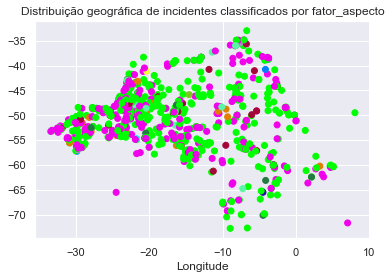

In [12]:
colors = distinctipy.get_colors(fator_aspecto.unique().shape[0])

cores_fatores = {fator: cor for fator, cor in zip(fator_aspecto.unique(), colors)}

cores_pontos = []

for fator in fator_aspecto:
    cores_pontos.append(cores_fatores[fator])

plt.scatter(latitudes, longitudes, c=cores_pontos)
plt.title('Distribuição geográfica de incidentes classificados por fator_aspecto')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('agrupamento_fator_aspecto.png', dpi=300)
plt.show()

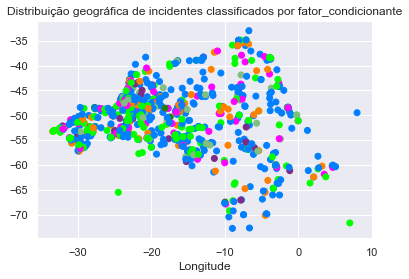

In [13]:

colors = distinctipy.get_colors(fator_condicionante.unique().shape[0])

cores_fatores = {fator: cor for fator, cor in zip(fator_condicionante.unique(), colors)}

cores_pontos = []

for fator in fator_condicionante:
    cores_pontos.append(cores_fatores[fator])

plt.scatter(latitudes, longitudes, c=cores_pontos)
plt.title('Distribuição geográfica de incidentes classificados por fator_condicionante')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('agrupamento_fator_condicionante.png', dpi=300)
plt.show()

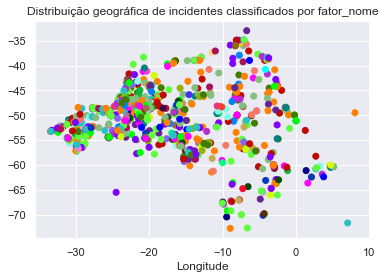

In [14]:
colors = distinctipy.get_colors(fator_nome.unique().shape[0])

cores_fatores = {fator: cor for fator, cor in zip(fator_nome.unique(), colors)}

cores_pontos = []

for fator in fator_nome:
    cores_pontos.append(cores_fatores[fator])

plt.scatter(latitudes, longitudes, c=cores_pontos)
plt.title('Distribuição geográfica de incidentes classificados por fator_nome')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('agrupamento_fator_nome.png', dpi=300)
plt.show()

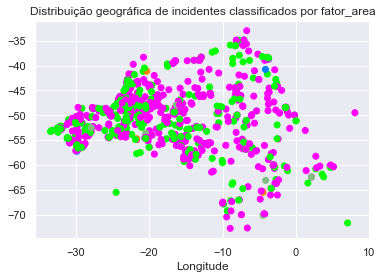

In [15]:
colors = distinctipy.get_colors(fator_area.unique().shape[0])

cores_fatores = {fator: cor for fator, cor in zip(fator_area.unique(), colors)}

cores_pontos = []

for fator in fator_area:
    cores_pontos.append(cores_fatores[fator])

plt.scatter(latitudes, longitudes, c=cores_pontos)
plt.title('Distribuição geográfica de incidentes classificados por fator_area')
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('agrupamento_fator_area.png', dpi=300)
plt.show()

Criamos todas as possível combinações de aeronaves para análise. Pegamos apenas dados não nulos.

In [38]:
tab_aeronave_clean = tab_aeronave.query(f"aeronave_tipo_veiculo != '***' & aeronave_motor_tipo != '***' & aeronave_motor_quantidade != '***'")
aeronave_tipo = tab_aeronave_clean['aeronave_tipo_veiculo'].unique()
aeronave_motor_tipo = tab_aeronave_clean['aeronave_motor_tipo'].unique()
aeronave_motor_quantidade = tab_aeronave_clean['aeronave_motor_quantidade'].unique()

combinacoes = list(product(aeronave_tipo, aeronave_motor_tipo, aeronave_motor_quantidade))


Obtemos a quantidade de ocorrencias por combinação e a quantidade de fatalidades por combinação

In [39]:
quantidades = {}
fatalidades = {}

for a_tipo, a_motor_tipo, a_motor_quantidade in tqdm(combinacoes):
    quantidades[(a_tipo, a_motor_tipo, a_motor_quantidade)] = tab_aeronave_clean.query(f"aeronave_tipo_veiculo == '{a_tipo}' & aeronave_motor_tipo == '{a_motor_tipo}' & aeronave_motor_quantidade == '{a_motor_quantidade}'").shape[0]
    
for a_tipo, a_motor_tipo, a_motor_quantidade in tqdm(combinacoes):
    fatalidades[(a_tipo, a_motor_tipo, a_motor_quantidade)] = tab_aeronave_clean.query(f"aeronave_tipo_veiculo == '{a_tipo}' & aeronave_motor_tipo == '{a_motor_tipo}' & aeronave_motor_quantidade == '{a_motor_quantidade}'")['aeronave_fatalidades_total'].sum()

Obtemos as fatalidades e quantidades não nula, ou seja diferentes de zero

In [40]:
fatalidades_nao_nulas = {combinacao: valor for combinacao, valor in fatalidades.items() if valor != 0}
quantidades_nao_nulas = {combinacao: valor for combinacao, valor in quantidades.items() if valor != 0}

Separamos os dados e plotamos num gráfico de barras horizontal. Podemos ver que a combinação com maior quantidade de fatalidades é a 'AVIÃO' 'PISTÃO' 'MONOMOTOR', com um total de aproximadamente 300.

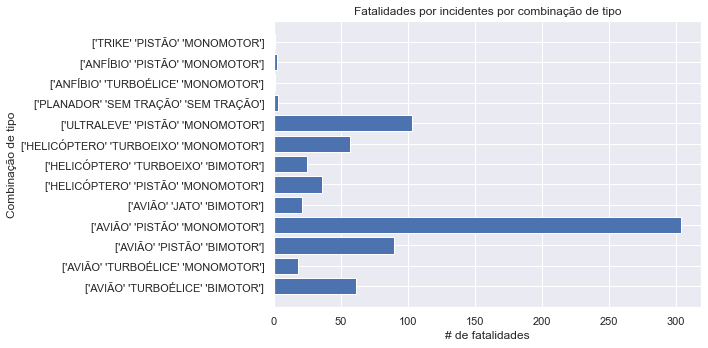

In [41]:
combinacoes_fatalidades = np.asarray(list(fatalidades_nao_nulas.keys()))
valores_fatalidades = np.asarray(list(fatalidades_nao_nulas.values()))

combinacoes_fatalidades_str = np.asarray([str(combinacao) for combinacao in combinacoes_fatalidades])

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(combinacoes_fatalidades_str, valores_fatalidades)
plt.title('Fatalidades por incidentes por combinação de tipo')
plt.xlabel('# de fatalidades')
plt.ylabel('Combinação de tipo')
plt.tight_layout()
plt.savefig('fatalidade_combinacao_tipo.png', dpi=300)
plt.show()

Separamos os dados e plotamos num gráfico de barras horizontal. Podemos ver que a combinação com maior quantidade de ocorrencias é a 'AVIÃO' 'PISTÃO' 'MONOMOTOR', com um total de mais de 1750.

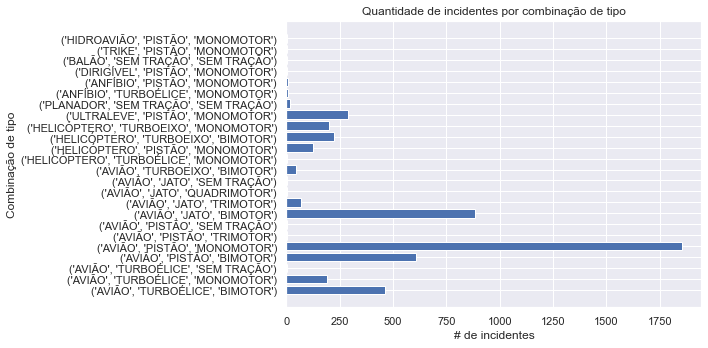

In [42]:
combinacoes_quantidades = list(quantidades_nao_nulas.keys())
valores_quantidades = list(quantidades_nao_nulas.values())

combinacoes_quantidades_str = [str(combinacao) for combinacao in combinacoes_quantidades]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(combinacoes_quantidades_str, valores_quantidades)
plt.title('Quantidade de incidentes por combinação de tipo')
plt.xlabel('# de incidentes')
plt.ylabel('Combinação de tipo')
plt.tight_layout()
plt.savefig('quantidade_combinação_tipo.png', dpi=300)
plt.show()

No entanto é necessário que normalizemos a quantidade de fatalidades pela quantidade de incidentes. Acontecem incidentes sem fatalidades e se uma combinação de itens de uma aeronave é mais propensa a levar fatalidades, é interessante que mais fiscalização aconteça sobre essa combinação.

In [43]:
fatalidades_normalizadas = {}

for combinacao in quantidades_nao_nulas:
    if combinacao in fatalidades_nao_nulas:
        fatalidades_normalizadas[combinacao] = float(fatalidades_nao_nulas[combinacao]/quantidades_nao_nulas[combinacao])

Podemos ver que quando acontece um incidente da combinação TRIKE, PISTAO, MONOMOTOR' sempre existem fatalidades.

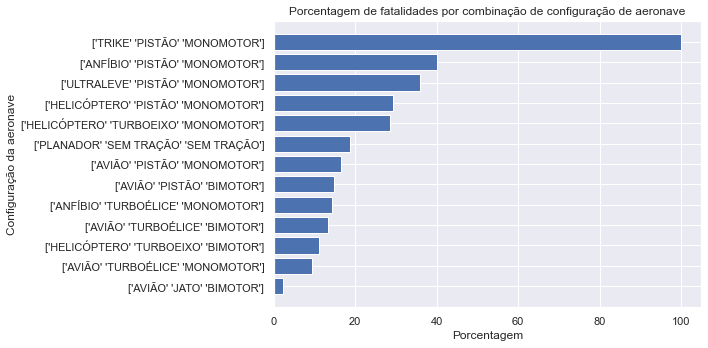

In [44]:
combinacoes_normalizadas = np.asarray(list(fatalidades_normalizadas.keys()))
combinacoes_valores_normalizados = np.asarray(list(fatalidades_normalizadas.values()))
indices_sem_nan = np.asarray([i for i, indice in enumerate(combinacoes_normalizadas) if '***' not in indice])
zipped = zip(combinacoes_normalizadas[indices_sem_nan], combinacoes_valores_normalizados[indices_sem_nan])
zipped = np.asarray(sorted(zipped, key = lambda x: x[1]))
#normalizada_causas = [str(causa) for causa in normalizada_causas]

rotulos = [str(rotulo) for rotulo in zipped[:, 0]]
valores_plot = zipped[:, 1].astype(float)*100

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(rotulos, valores_plot)
plt.title('Porcentagem de fatalidades por combinação de configuração de aeronave')
plt.xlabel('Porcentagem')
plt.ylabel('Configuração da aeronave')
plt.tight_layout()
plt.savefig('fatalidades_normalizadas.png', dpi=300)
plt.show()

Um outro fator interessante para análise é em que etapa do voo acontecem incidentes, para que maior atenção possa ser prestada nessa etapa.

In [45]:
fases = tab_aeronave['aeronave_fase_operacao'].unique()
fases = fases[:-1]

incidentes_por_fase = {}

for fase in fases:
    incidentes_por_fase[fase] = (tab_aeronave.query(f"aeronave_fase_operacao == '{fase}'").shape[0])

Podemos ver que o pouso e a decolagem são as fases com maior quantidade de incidentes, seguidos pelo cruzeiro. Durante o cruzeiro é extremamente difícil prestar auxílio à aeronave, então durante as duas outras fases a atenção dos controladores de voo deve ser a maior possível; para que possamos prestar socorro ou até mesmo evitar os incidentes.

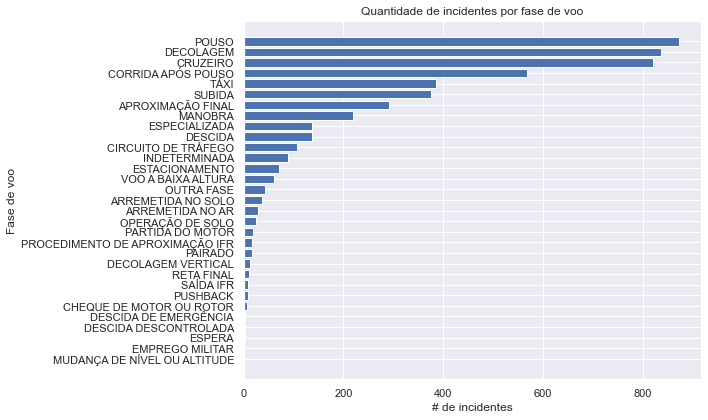

In [52]:
fases = np.asarray(list(incidentes_por_fase.keys()))
quantidade_incidentes = np.asarray(list(incidentes_por_fase.values()))

zipped = zip(fases, quantidade_incidentes)
zipped = np.asarray(sorted(zipped, key = lambda x: x[1]))

rotulos = [str(rotulo) for rotulo in zipped[:, 0]]
valores_plot = zipped[:, 1].astype(float)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(rotulos, valores_plot)
plt.title('Quantidade de incidentes por fase de voo')
plt.xlabel('# de incidentes')
plt.ylabel('Fase de voo')
plt.tight_layout()
plt.savefig('incidentes_fase.png', dpi=300)
plt.show()

In [54]:
incidentes_por_mes_ano_operadora = {}
   
for idx, data in tqdm(enumerate(tab_reportes_2011_2020['data']), total=tab_reportes_2011_2020['data'].shape[0]):
    mes = data[3:5]
    ano = data[6:]
    operadora = tab_reportes_2011_2020['operador'][idx]
    
    if operadora == 'LATAM':
        operadora = 'TAM'
    elif operadora == 'Azul':
        operadora = 'AZU'
    elif operadora == 'GOL - Varig':
        operadora = 'GLO'
    
    if ano == '2020':#= '0 Desconhecido (UNKNOWN)':
        if (mes, ano, operadora) not in incidentes_por_mes_ano_operadora:
            incidentes_por_mes_ano_operadora[(mes, ano, operadora)] = 0
        else:
            incidentes_por_mes_ano_operadora[(mes, ano, operadora)] += 1

In [55]:
chaves = np.asarray(list(incidentes_por_mes_ano_operadora.keys()))
quantidade_incidentes = np.asarray(list(incidentes_por_mes_ano_operadora.values()))

zipped = zip(chaves, quantidade_incidentes)
zipped = np.asarray(sorted(zipped, key = lambda x: (x[0][2], x[0][1], x[0][0])))

In [56]:
arquivos_voos = glob('./anac/voos_2020/*.csv')
empresas = ['TAM', 'AZU', 'GLO']
porcentagem_ocorrencias_por_operador = {}
for idx, arquivo in enumerate(sorted(arquivos_voos)):
    #print(arquivo)
    voos = pd.read_csv(arquivo, sep=';', engine='python')
    voos = voos[voos['Situacao Voo'] == 'REALIZADO']
    #print(voos.columns)
    #voos = voos.rename(columns={'ICAO Empresa Aerea':'empresa'})
    
    mes = arquivo.split('_')[2]
    porcentagem_ocorrencias_por_operador_por_mes = {}    

    for empresa in empresas:
        if (mes, '2020', empresa) in incidentes_por_mes_ano_operadora:
            n_incidentes = incidentes_por_mes_ano_operadora[(mes, '2020', empresa)]
        else:
            n_incidentes = 0
        n_voos = voos.query(f"empresa == '{empresa}'").shape[0]
        porcentagem_ocorrencias_por_operador[(empresa, mes)] = n_incidentes/n_voos
    


In [57]:
valores_plot = []
rotulos = []
for chave in porcentagem_ocorrencias_por_operador:
    valores_plot.append(porcentagem_ocorrencias_por_operador[(chave)])
    rotulos.append(f'{chave[0]}-{chave[1]}')

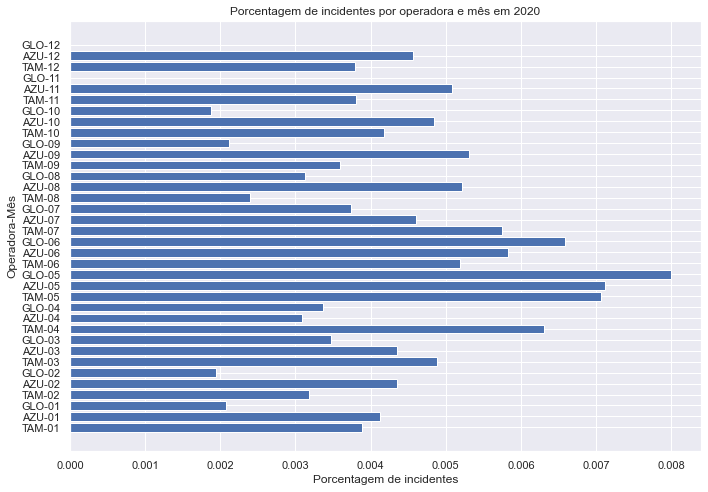

In [58]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(rotulos, np.asarray(valores_plot))
plt.title('Porcentagem de incidentes por operadora e mês em 2020')
plt.xlabel('Porcentagem de incidentes')
plt.ylabel('Operadora-Mês')
plt.tight_layout()
plt.savefig('incidentes_mes_operadora.png', dpi=300)
plt.show()